In [43]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

import pandas as pd
import pickle

from itertools import product

In [44]:
df = pd.read_pickle("NYC_listing_pickle")

In [45]:
df.head(15)

,host_since,city,zipcode,latitude,longitude
id,,,,,
3943387,2014-08-23,Bronx,10464,40.839396,-73.781437
6627449,2014-04-04,City Island,10464,40.849775,-73.786609
11675715,2016-01-30,City Island,10464,40.850376,-73.784681
1886820,2013-11-04,Bronx,10464,40.841144,-73.783052
5557381,2015-03-05,Bronx,10464,40.850024,-73.789328
958444,2013-02-24,Bronx,10464,40.852350,-73.788728
8053533,2015-08-25,Bronx,10464,40.848202,-73.789293
9147025,2011-02-21,Bronx,10464,40.844870,-73.789541
7949480,2010-05-06,Bronx,10464,40.852054,-73.788680


In [46]:
def replaceZipcodes(zipcodes,newZipcodes):
    '''replaces the zipcode in the dataframe with 
    a new zipcode'''
    for i,z in zip(zipcodes,newZipcodes):
        index = df[df['zipcode'] == i].index.tolist()
        df.set_value(index,'zipcode',z).head(5)

In [47]:
zipcodes = ['11426-1175','10002-2289','10003\n10003','10003-8623','11205-4471','8456422473 call for more details','11103-3233']
newZipcodes = ['11426','10002','10003','10003','11205','10021','11103']
replaceZipcodes(zipcodes,newZipcodes)

#### We defined each neighborhood to be 1x1 mile. Using a calculator (see index below), we found the distance of the longitude to be 32.64 miles (52.53 km) by longitude and 33.64 miles (54.13 km) by latitude. 

### Assumptions

#### We assume every listing in airbnb listing.csv is unique and represents a different home/apartment/sublet (living residence). Furthermore, we will find the number of houses in a neighborhood using motovo.com. All homes listed on motovo.com when we input the zipcode, will represent the number of homes in that zipcode and the neighborhood. 

In [48]:
import geopy

In [49]:
df.zipcode.head(10) # need to count how many zipcodes are NaN

id
3943387     10464
6627449     10464
11675715    10464
1886820     10464
5557381     10464
958444      10464
8053533     10464
9147025     10464
7949480     10464
755528      10467
Name: zipcode, dtype: object

In [50]:
coordinateList = zip(df.latitude, df.longitude, df.zipcode)

In [51]:
max_lat = df.max(axis=0)['latitude']
max_long =  df.max(axis=0)['longitude']
min_lat = df.min(axis=0)['latitude']
min_long = df.min(axis=0)['longitude']
max_long_row = df.loc[df['longitude']== max_long]
min_long_row = df.loc[df['longitude']== min_long]
max_lat_row = df.loc[df['latitude']== max_lat]
min_lat_row = df.loc[df['latitude']== min_lat]
corresponding_long_of_min_lat = -74.240843
corresponding_lat_of_min_long = 40.499794

In [52]:
from geopy import distance

def find_distance(in_lat, in_long):
    '''Paramters: Lat and long of house listing.
       Output: 0 < lat < 33.64 and 0 < long < 32.64
       We calculate the long difference and lat difference by isolating the variables and fixing the other 
       to be the corresponding fixed varaible of the minimum free variable. 
    '''
    diff_long = distance.vincenty((corresponding_lat_of_min_long, in_long), (corresponding_lat_of_min_long, min_long)).miles
    diff_lat = distance.vincenty((in_lat,  corresponding_long_of_min_lat), (min_lat, corresponding_long_of_min_lat)).miles
    return (diff_lat, diff_long)

In [53]:
find_distance(40.783605,-73.967515)

(19.58333832402766, 14.396840047098028)

In [54]:
import math
n_grid = {}
n_grid_zipcodes = {}

def isNaN(num):
    return num != num

from decimal import *
getcontext().prec = 2

def round_num(x):
    return int(x)
   # return float("{0:.2f}".format(x))
index = 0
for coor in coordinateList:
    latitude,longitude, zipcode = coor
    res_distance = find_distance(latitude,longitude)
    out_distance = (round_num(res_distance[0]), round_num(res_distance[1]))
    # places lat,long values in zipcode grid
    if isNaN(zipcode) is False:
        if type(zipcode) is float:
            zipcode = int(zipcode) 
        zipcode = str(zipcode)
        if n_grid_zipcodes.get(zipcode) is None:
            n_grid_zipcodes[zipcode] = set() 
        n_grid_zipcodes[zipcode].add(out_distance)
        
    # counts the number of neighborhoods per zipcode
    if  n_grid.get(out_distance) is None:
        n_grid[out_distance] = []
    else:
        n_grid[out_distance].append(index)
    index = index + 1

In [55]:
# n_grid 

In [56]:
# import json
# with open('n_grid.txt', 'w') as outfile:
#     json.dump(str(n_grid), outfile)

In [57]:
# n_grid_zipcodes

In [58]:
n = len(n_grid_zipcodes)

In [59]:
n

201

In [60]:
from itertools import islice
def take(n,iterable):
    ''''Return first n iterms of the iterable as a list'''
    return list(islice(iterable,n))

In [61]:
firstHalfOrig = [10270,10279,10280,10281,10282,12337,10301,10303,10304,10305,10308,10312,10314,11354,11355,11356,11357,
11358,11360,11361,11362,11364,11365,11366,11367,11368,11369,11370,11372,11373,11374,11375,11377,11379,11385,10080,7305,
11411,11412,11413,11415,11416,11417,11418,11419,11421,11423,11426,11427,11432,11434,11435,10451,10452,10453,10454,
10455,10456,10457,10458,10459,10460,10462,10463,10464,10465,10466,10467,10468,10469,10471,10472,10473,10475,11001,
11004,10001,10002,10003,10004,10005,10006]

In [62]:
firstHalfOrigString = [str(i) for i in firstHalfOrig]
b = set(firstHalfOrigString)

In [63]:
allZipcodes = take((n),n_grid_zipcodes)
c = set(allZipcodes)

In [64]:
secondHalfOrig = c-b

In [65]:
relative_times = {}
import time
from datetime import datetime
        
def findMin():
    '''find the pioneer - the first home in a
    neighborhood to be listed on Airbnb'''
    min_hashmap = {}
    for key, value in n_grid.iteritems():
        if len(value) > 0:
            min_value = time.strftime("%Y-%m-%d")
            for i in range(len(value)):
                host_since = df.iloc[i].host_since
                host_datetime = time.strptime(host_since, "%Y-%m-%d")
                if min_value < host_datetime:
                    min_value = host_since
            min_hashmap[key] = [min_value]
    return min_hashmap

min_hashmap = findMin()    

In [66]:
def get_relative_times():
    '''Calculate the age of house listings in neighborhood based on
    pioneer'''
    relative_times = {}
    for key, value in n_grid.iteritems():
        if len(value) > 0:
            min_time = min_hashmap[key]
            min_time_l = datetime.strptime(min_time[0],"%Y-%m-%d")
            for i in range(len(value)):
                index = value[i]
                curr_since = df.iloc[index].host_since
                if type(curr_since) is not float:
                    curr_datetime = datetime.strptime(str(curr_since),"%Y-%m-%d")
                    diff = abs((curr_datetime - min_time_l).days) 
                    diff_months = math.floor(diff/30)
                    if relative_times.get(key) is None:
                        relative_times[key] = [str(diff_months)]
                    else:
                        relative_times[key].append(str(diff_months))
    return relative_times

relative_times = get_relative_times()

In [67]:
# import json
# with open('min_hashmap.txt', 'w') as outfile:
#     json.dump(str(min_hashmap), outfile)

In [68]:
# with open('relative_hashmap_months.txt', 'w') as outfile:
#     json.dump(str(relative_times), outfile)

In [69]:
def prepareData(grid,rel_hash):
    '''iterate through each neighborhood in grid and format 
    each listing as (isListed,age).
    isListed: a boolean value
    age: number of days that have passed since pioneer was listed on Airbnb
    
    Return a dictionary where the key is the neighborhood coordinates
    and the value is a list of tuples. Each tuple represents a home in that neighborhood'''
    n_dict = {}
    for key, val in grid.iteritems():
        homes = []
        if len(val) > 0:
#             print (key)
#             print (val)
            listedHomes = rel_hash[key]
            for age in listedHomes:
                f_age = float(age)
                homes.append((True,int(f_age)))
            n_dict[key] = homes
        else:
            pass
    return n_dict
        

In [70]:
neighborhoodData = prepareData(n_grid,relative_times)

In [71]:
# neighborhoodData

In [72]:
len15_17 = len(neighborhoodData[(15,27)])
len10_17 = len(neighborhoodData[(10,17)])

In [73]:
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

In [74]:
class Airbnb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam,k = hypo
        if lam == 0:
            return 0
        isListed,age = data
        if isListed == True:
            like = EvalWeibullPdf(age, lam, k)
        elif isListed == False:
            like = 1 - EvalWeibullCdf(age, lam, k)
        else:
#             print (isListed)
            raise ValueError('Invalid data')
        return like

In [75]:
lams = np.linspace(0, 10, 100)
ks = np.linspace(0, 10, 100)

suite = Airbnb(product(lams, ks))

In [76]:
data = neighborhoodData[(15,17)]

In [77]:
len(data)

9

In [78]:
data

[(True, 44),
 (True, 44),
 (True, 68),
 (True, 62),
 (True, 66),
 (True, 69),
 (True, 34),
 (True, 64),
 (True, 22)]

In [79]:
suite.UpdateSet(data)

8.666482967908534e-27

8.6160134099456513

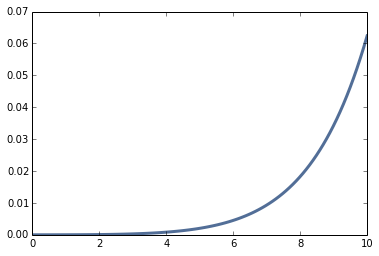

In [80]:
lam = suite.Marginal(0)
thinkplot.Pdf(lam)
lam.Mean()

0.44980655755266707

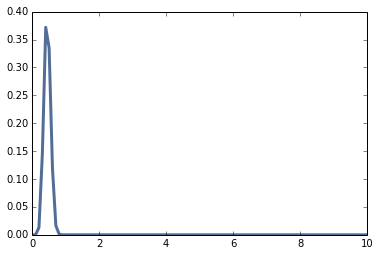

In [81]:
k = suite.Marginal(1)
thinkplot.Pdf(k)
k.Mean()

In [82]:
from collections import Counter
C = Counter(neighborhoodData)
len(C.most_common(1)[0][1])

1049

In [83]:
# C.most_common(4)